# IEEE Fraud Detection

Alunos : Victor e Lucas

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.impute import SimpleImputer

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

sns.set_theme()

## 1 - Carregando os datasets

In [2]:
df_train_id = pd.read_csv("train_identity.csv")
df_train_tr = pd.read_csv("train_transaction.csv")
df_test_id = pd.read_csv("test_identity.csv")
df_test_tr = pd.read_csv("train_transaction.csv")

In [3]:
df_train_id.shape, df_train_tr.shape, df_test_id.shape, df_test_tr.shape

((144233, 41), (590540, 394), (141907, 41), (590540, 394))

In [4]:
df_train = pd.merge(df_train_tr, df_train_id, on='TransactionID', how='left')
df_test = pd.merge(df_test_tr, df_test_id, on='TransactionID', how='left')
df_test, df_val = train_test_split(df_test, test_size=0.2, random_state=42, stratify=df_test['isFraud'])

In [5]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(590540, 434)
(472432, 434)
(118108, 434)


In [6]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
df_test.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
40809,3027809,0,1008491,100.00,R,6177,399.0,150.0,american express,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285886,3272886,0,7008212,29.99,W,7900,345.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104256,3091256,0,2071522,107.95,W,11690,111.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
507860,3494860,0,13299752,241.95,W,2616,327.0,150.0,discover,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196382,3183382,0,4412283,117.00,W,13780,298.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Variável alvo
target = df_train['isFraud'].value_counts()
target

0    569877
1     20663
Name: isFraud, dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


## 2 - Análise Exploratória

### Transaction Amount

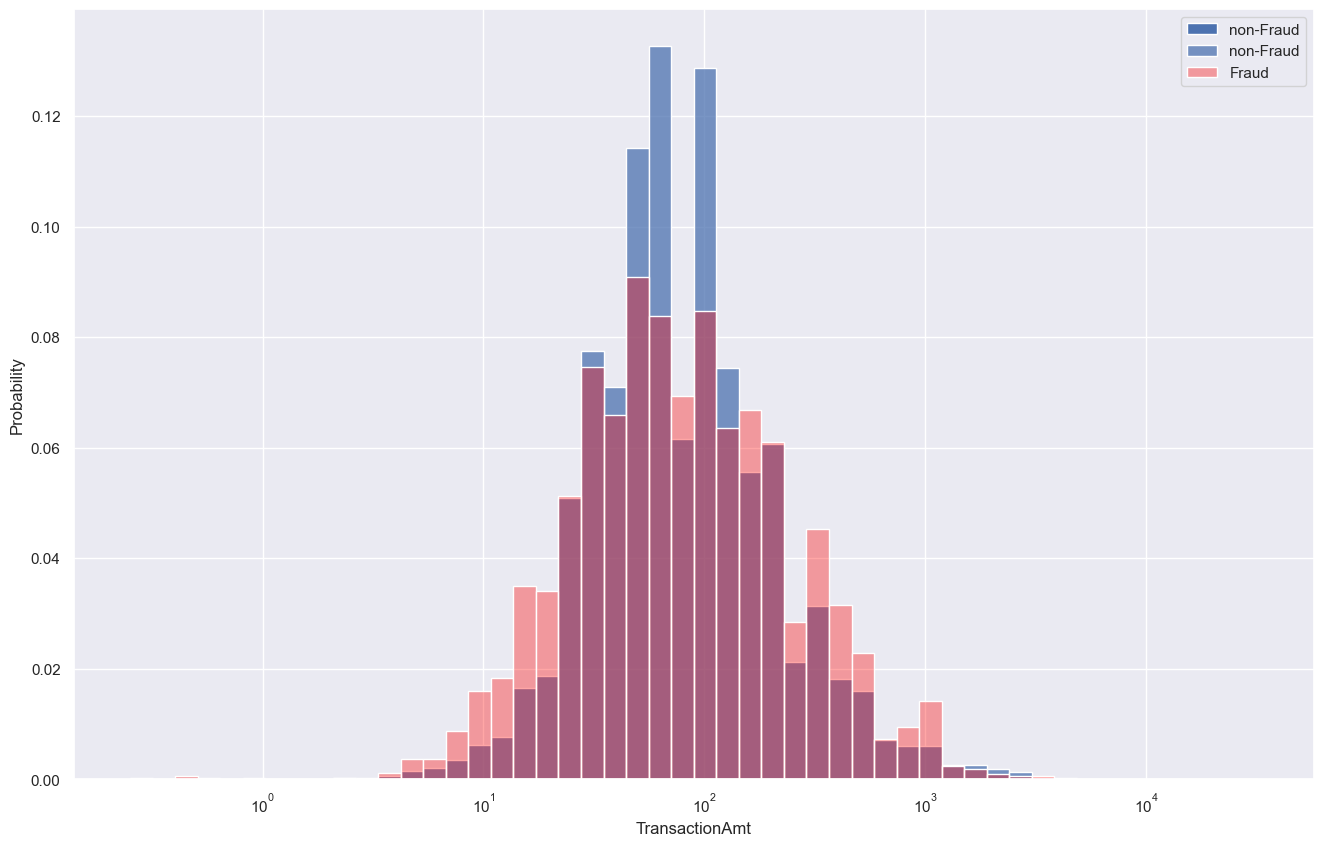

In [10]:
bins = np.histogram_bin_edges(np.log10(df_train['TransactionAmt']), bins=50)

plt.figure(figsize=(16,10))

# plt.subplot(121)
px = sns.histplot(data=df_train, x='TransactionAmt', label='non-Fraud',
                  bins=bins, stat='probability', log_scale=True)


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True], x='TransactionAmt', bins=bins,
                   stat='probability', log_scale=True, color='red', alpha=0.35, label='Fraud')


plt.legend()
plt.show()

### TransactionDT

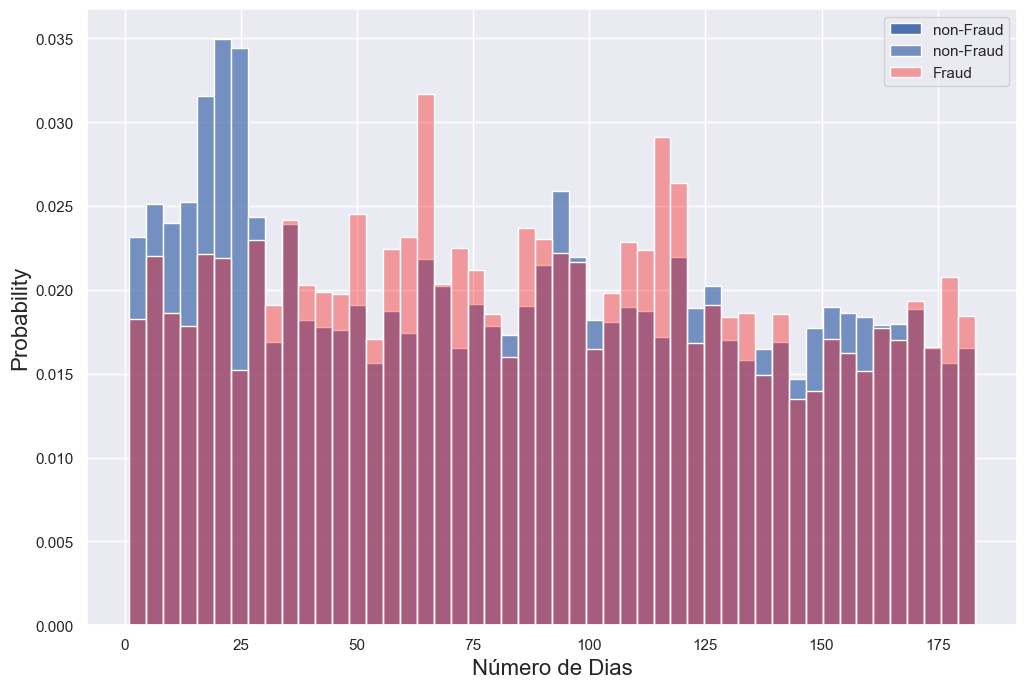

In [11]:
bins = np.histogram_bin_edges(df_train['TransactionDT'] / 86400, bins=50)

fig = plt.figure(figsize=(12,8))

# plt.subplot(121)
px = sns.histplot(data=df_train['TransactionDT'] / 86400, label='non-Fraud',
                  bins=bins, stat='probability')


# plt.subplot(122)    
px2 = sns.histplot(data=df_train[df_train['isFraud'] == True]['TransactionDT'] / 86400, bins=bins,
                   stat='probability', color='red', alpha=0.35, label='Fraud')

px2.set_xlabel('Número de Dias', fontsize=16)
px2.set_ylabel('Probability', fontsize=16)
plt.legend()
plt.show()

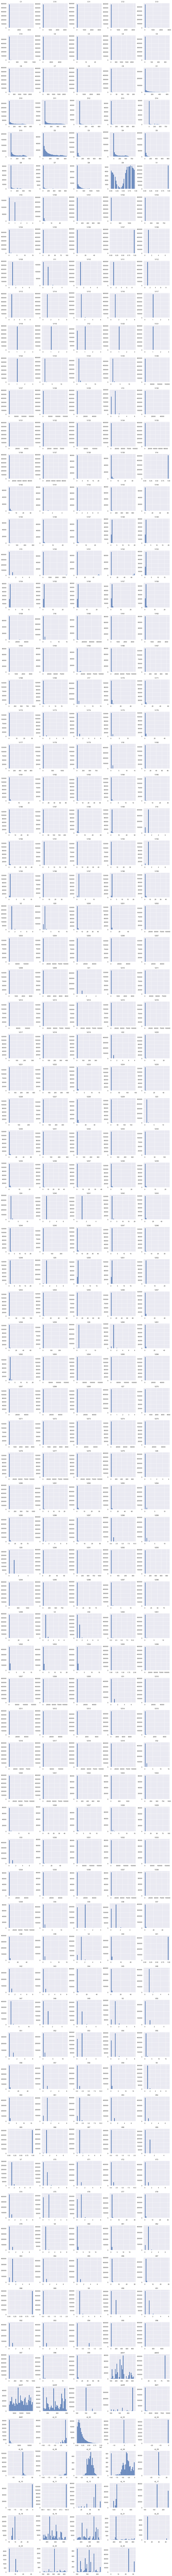

In [12]:
df_train[df_train.columns.difference(['TransactionID', 'TransactionDT', 'isFraud', 'TransactionAmt'])].hist(figsize=(20,348), layout=(87, 5), bins=30);

### Avaliando o tipo de aparelho em que a transação foi realizada

In [13]:
categorical_columns = df_train.select_dtypes(exclude=np.number).columns.to_list()

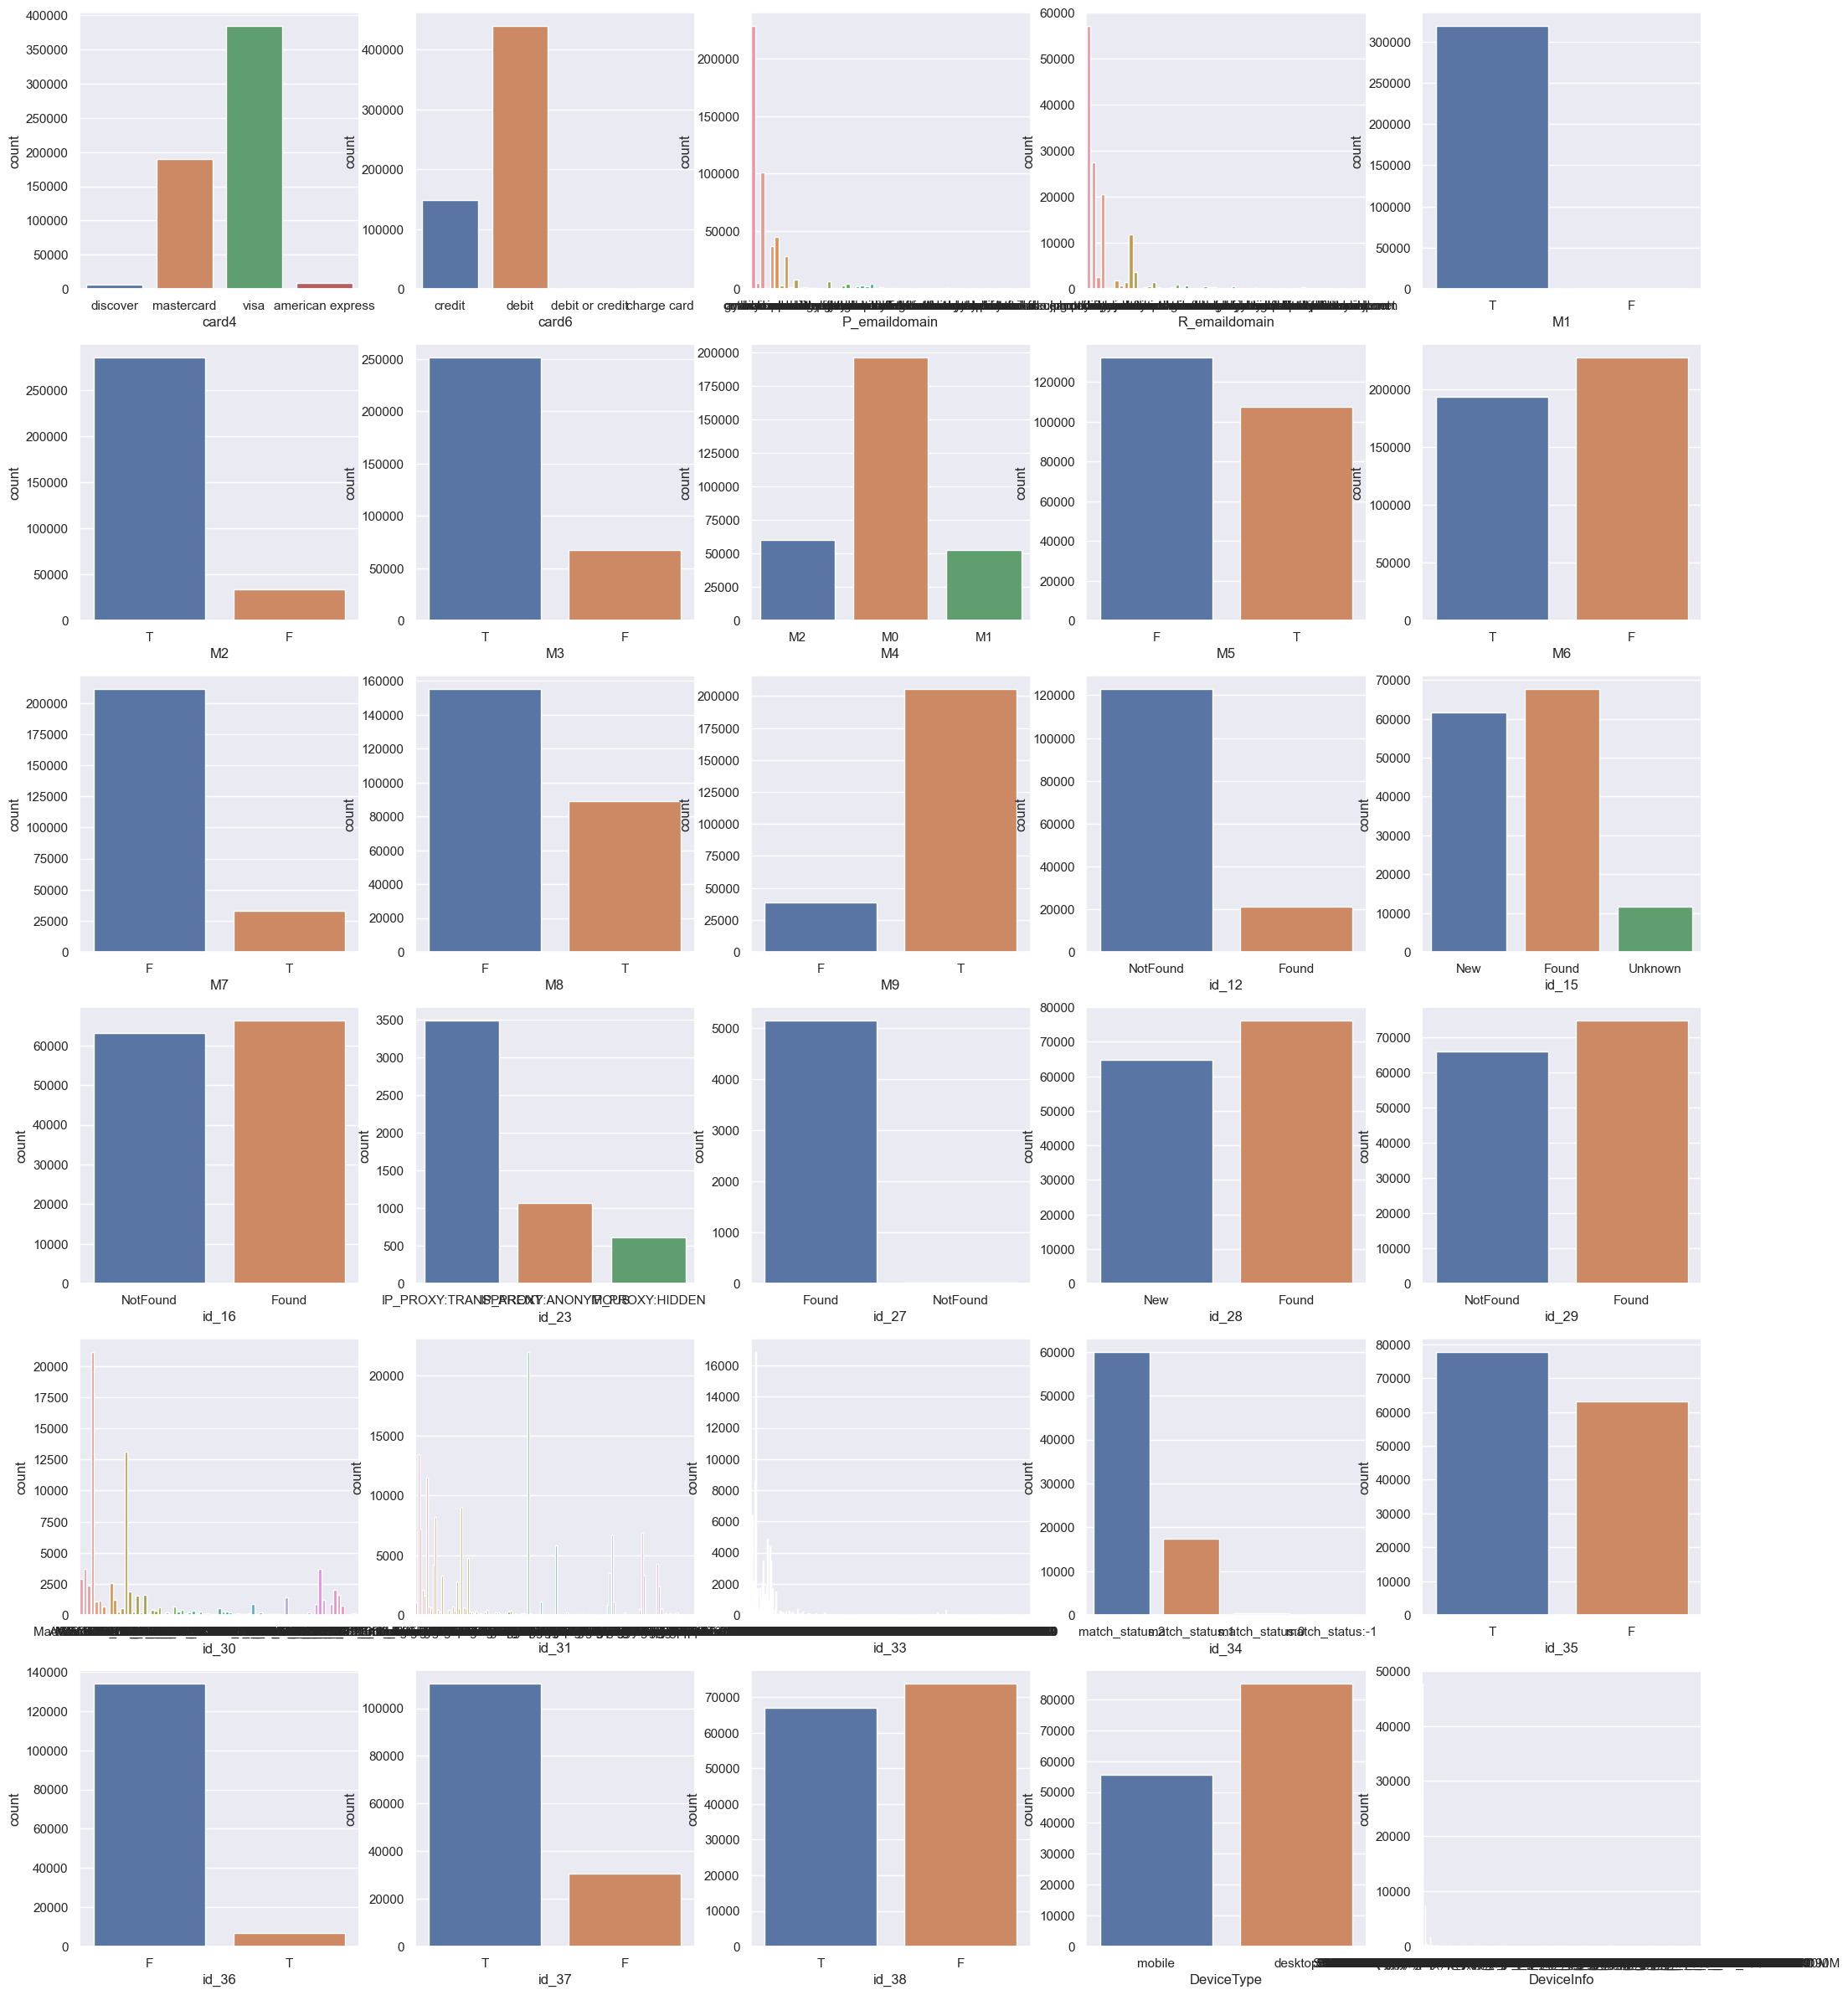

In [14]:


fig, axes = plt.subplots(6, 5, figsize=(25, 30))

aux = 1

for row in axes:
    for column in row:
        
        sns.countplot(data=df_train, x=categorical_columns[aux], ax=column)
        aux += 1


plt.show()

## 3 - Feature Engineering

### Fixing the problemns of 'id' columns with diff names

df_train -> ['id_01'] & df_val, df_test -> ['id-01']

In [15]:
columns_name = df_train.columns.to_list()

df_val.columns = columns_name
df_test.columns = columns_name

### P_emaildomain

In [16]:
df_train['P_emaildomain'].unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

In [17]:
# Reagrupando os domínios de e-mail (df_train)

def group_email_domain(pattern, email_domain, df):
    df['P_emaildomain'].replace(pattern, email_domain, regex=True, inplace=True)
    df['R_emaildomain'].replace(pattern, email_domain, regex=True, inplace=True)

gmail_match = re.compile(r'.*(gmail).*')

group_email_domain(gmail_match, 'gmail', df_train)
group_email_domain(gmail_match, 'gmail', df_test)
group_email_domain(gmail_match, 'gmail', df_val)

yahoo_match = re.compile(r'.*(yahoo).*')

group_email_domain(yahoo_match, 'yahoo', df_train)
group_email_domain(yahoo_match, 'yahoo', df_test)
group_email_domain(yahoo_match, 'yahoo', df_val)

microsoft_match = re.compile(r'.*(hotmail|outlook|live|msn).*')

group_email_domain(microsoft_match, 'microsoft', df_train)
group_email_domain(microsoft_match, 'microsoft', df_test)
group_email_domain(microsoft_match, 'microsoft', df_val)

others_match = re.compile(r'.*[^gmail|yahoo|microsoft].*')

group_email_domain(others_match, 'others', df_train)
group_email_domain(others_match, 'others', df_test)
group_email_domain(others_match, 'others', df_val)


In [18]:
df_test['R_emaildomain'].value_counts(normalize=True)

gmail        0.416140
microsoft    0.245635
others       0.238629
yahoo        0.099595
Name: R_emaildomain, dtype: float64

### DeviceInfo

In [19]:
len(df_train['DeviceInfo'].unique())

1787

In [20]:
df_train[['DeviceInfo', 'DeviceType']].value_counts(normalize=True).head(10)

DeviceInfo             DeviceType
Windows                desktop       0.402290
iOS Device             mobile        0.166758
MacOS                  desktop       0.105926
Trident/7.0            desktop       0.062443
rv:11.0                desktop       0.015714
rv:57.0                desktop       0.007343
SM-J700M Build/MMB29K  mobile        0.004628
SM-G610M Build/MMB29K  mobile        0.003886
SM-G531H Build/LMY48B  mobile        0.003372
SM-G935F Build/NRD90M  mobile        0.002816
dtype: float64

In [21]:
# Reagrupando os Devices

def group_device_info(pattern, device_info, df):
    df['DeviceInfo'].replace(pattern, device_info, regex=True, inplace=True)


windows = re.compile(r'.*(Windows|rv:|Trident/).*')

group_device_info(windows, 'Windows', df_train)
group_device_info(windows, 'Windows', df_train)
group_device_info(windows, 'Windows', df_train)

samsung = re.compile(r'.*(SM-|SAMSUNG).*')

group_device_info(samsung, 'Samsung', df_train)
group_device_info(samsung, 'Samsung', df_test)
group_device_info(samsung, 'Samsung', df_val)

android = re.compile(r'.*(Android|Moto|LG-).*')

group_device_info(android, 'Android', df_train)
group_device_info(android, 'Android', df_test)
group_device_info(android, 'Android', df_val)

huawei = re.compile(r'.*(HUAWEI|ALE-).*')

group_device_info(huawei, 'Huawei', df_train)
group_device_info(huawei, 'Huawei', df_test)
group_device_info(huawei, 'Huawei', df_val)

others = re.compile(r'.*[^Windows|Samsung|Android|Huawei].*')

group_device_info(others, 'Others', df_train)
group_device_info(others, 'Others', df_test)
group_device_info(others, 'Others', df_val)

In [22]:
df_train['DeviceInfo'].value_counts().head(10)

Windows    59600
Others     39538
Samsung    11940
Android     5264
Huawei      2315
Hisense        9
Name: DeviceInfo, dtype: int64

### Id-30, Id-31, Id-33

In [23]:
def group_id(pattern, new_info, df):
    df['id_30'].replace(pattern, new_info, regex=True, inplace=True)

windows = re.compile(r'.*(Windows).*')

group_id(windows, 'Windows', df_train)
group_id(windows, 'Windows', df_test)
group_id(windows, 'Windows', df_val)

ios = re.compile(r'.*(iOS).*')

group_id(ios, 'iOS', df_train)
group_id(ios, 'iOS', df_test)
group_id(ios, 'iOS', df_val)

mac = re.compile(r'.*(Mac).*')

group_id(mac, 'Mac', df_train)
group_id(mac, 'Mac', df_test)
group_id(mac, 'Mac', df_val)

android = re.compile(r'.*(Android).*')

group_id(android, 'Android', df_train)
group_id(android, 'Android', df_test)
group_id(android, 'Android', df_val)


In [24]:
df_train.drop(columns=['id_31', 'id_33'], inplace=True)
df_test.drop(columns=['id_31', 'id_33'], inplace=True)
df_val.drop(columns=['id_31', 'id_33'], inplace=True)

## 4 - Treinamento do Modelo Baseline **pré** Feature Engineering

Nesse tópico, os modelos baseline serão treinados com o dataset completo, sem remoção de features (sem redução de dimensionalidade).

### Splitting data

In [25]:
categorical_selector = make_column_selector(dtype_exclude=np.number)
numerical_selector = make_column_selector(dtype_include=np.number)

categorical_columns = df_train[categorical_selector].columns

df_train[categorical_columns] = df_train[categorical_columns].fillna('Uknown')
df_test[categorical_columns] = df_test[categorical_columns].fillna('Uknown')
df_val[categorical_columns] = df_val[categorical_columns].fillna('Uknown')


def df_subset(df, size):
    df_sub = df.sample(frac=size, replace=False, random_state=42)

    return df_sub

df_train_05 = df_subset(df_train, 0.05)
df_train_10 = df_subset(df_train, 0.1)
df_train_20 = df_subset(df_train, 0.2)
df_train_50 = df_subset(df_train, 0.5)


for df in [df_train_05, df_train_10, df_train_20, df_train_50, df_train]:
    print(df.shape[0])

29527
59054
118108
295270
590540


In [26]:
def split_x_y(df):
    X = df.drop(['isFraud'], axis=1)
    y = df.loc[:, 'isFraud']
    
    return X, y

X_train_05, y_train_05 = split_x_y(df_train_05)
X_train_10, y_train_10 = split_x_y(df_train_10)
X_train_20, y_train_20 = split_x_y(df_train_20)
X_train_50, y_train_50 = split_x_y(df_train_50)
X_train, y_train = split_x_y(df_train)

X_val, y_val = split_x_y(df_val)

X_test, y_test = split_x_y(df_test)

### Baseline Simples (Regressão Logística)

In [27]:
encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_selector),
    (SimpleImputer(strategy='median'), numerical_selector))

def simple_baseline(X_train, y_train, X_val, y_val):

    pipe = make_pipeline(
        encode_categorical,
        LogisticRegression(class_weight='balanced', random_state=42))
    
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict_proba(X_val)[:, 1]
    
    print(f"Val ROC AUC score: {roc_auc_score(y_val, y_pred)}")

    return roc_auc_score(y_val, y_pred)

In [29]:
import time
roc_lr = []

for (x_train_, y_train_) in [
    (X_train_05, y_train_05),
    (X_train_10, y_train_10),
    (X_train_20, y_train_20),
    (X_train_50, y_train_50),
    (X_train, y_train)
]:
    now = time.time()
    print(f"Training with {x_train_.shape[0]} samples ({x_train_.shape[0] / df_train.shape[0]:.0%})")
    roc_lr.append(simple_baseline(x_train_, y_train_, X_val, y_val))
    end = time.time()
    print(f"Time elapsed: {end - now} seconds\n")

Training with 29527 samples (5%)


c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Val ROC AUC score: 0.7012597889211997
Time elapsed: 4.5670249462127686 seconds

Training with 59054 samples (10%)


c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Val ROC AUC score: 0.5686232866850398
Time elapsed: 6.8651978969573975 seconds

Training with 118108 samples (20%)


c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Val ROC AUC score: 0.6231843007667781
Time elapsed: 12.582247257232666 seconds

Training with 295270 samples (50%)


c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Val ROC AUC score: 0.6650675566053422
Time elapsed: 34.01608991622925 seconds

Training with 590540 samples (100%)


c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Val ROC AUC score: 0.649178714307724
Time elapsed: 84.2672369480133 seconds



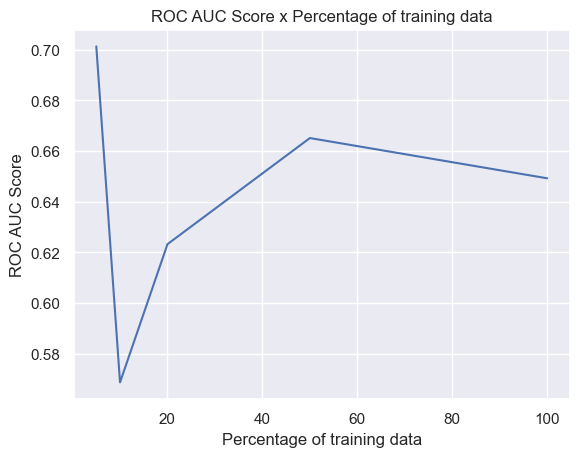

In [30]:
g = sns.lineplot(x=[5, 10, 20, 50, 100], y=roc_lr);

g.set_xlabel('Percentage of training data')
g.set_ylabel('ROC AUC Score')
g.set_title('ROC AUC Score x Percentage of training data');

Como podemos observar, ao treinar o dataset completo, a Regressão Logística acaba por não convergir. 

Então, torna-se mais interessante utilizar uma baseline com Random Forest.

### Baseline Complexa (Random Forest)

In [31]:
def complex_baseline(X_train, y_train, X_val, y_val):

    pipe = make_pipeline(
        encode_categorical,
        RandomForestClassifier(min_samples_split=10, class_weight='balanced', random_state=42, n_estimators=50, n_jobs=-1)
        )
    
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict_proba(X_val)[:, 1]
    
    print(f"Val ROC AUC score: {roc_auc_score(y_val, y_pred)}")

    return roc_auc_score(y_val, y_pred)

In [32]:
import time
roc_rf = []

for (x_train_, y_train_) in [
    (X_train_05, y_train_05),
    (X_train_10, y_train_10),
    (X_train_20, y_train_20),
    (X_train_50, y_train_50),
    (X_train, y_train)
]:
    now = time.time()
    print(f"Training with {x_train_.shape[0]} samples ({x_train_.shape[0] / df_train.shape[0]:.0%})")
    roc_rf.append(complex_baseline(x_train_, y_train_, X_val, y_val))
    end = time.time()
    print(f"Time elapsed: {end - now} seconds\n")

Training with 29527 samples (5%)
Val ROC AUC score: 0.8786999698073705
Time elapsed: 5.3011720180511475 seconds

Training with 59054 samples (10%)
Val ROC AUC score: 0.8989911118821875
Time elapsed: 8.518575191497803 seconds

Training with 118108 samples (20%)
Val ROC AUC score: 0.9202960395538837
Time elapsed: 15.798831224441528 seconds

Training with 295270 samples (50%)
Val ROC AUC score: 0.9608050642523461
Time elapsed: 43.8517861366272 seconds

Training with 590540 samples (100%)
Val ROC AUC score: 0.994857666085865
Time elapsed: 110.1831579208374 seconds



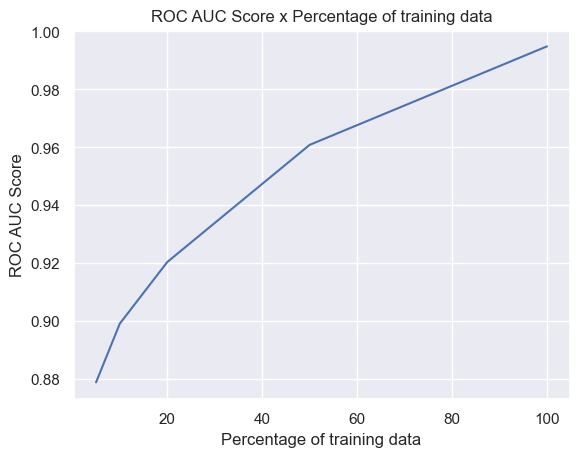

In [33]:
g = sns.lineplot(x=[5, 10, 20, 50, 100], y=roc_rf);

g.set_xlabel('Percentage of training data')
g.set_ylabel('ROC AUC Score')
g.set_title('ROC AUC Score x Percentage of training data');

Devido ao elevado tempo de treinamento e visando otimizar os hiperparâmetros do modelo com validação cruzada, utilizaremos apenas 20% do dataset de treino para treinar o modelo.

## 5 - Redução de Dimensionalidade

Remoção de features com correlação maior que 0.95%

In [34]:
corr = X_train.select_dtypes(include=np.number).corr()

In [35]:
def get_most_corr_columns(corr, threshold):
    d = {}
    for index in corr.columns:
        d[index] = {'num': 0, 'cols': []}
        for col in corr.columns:
            if index != col:
                if corr.at[index, col] > threshold:
                    d[index]['num'] += 1
                    d[index]['cols'].append(col)
                    

    return sorted(d.items(), key=lambda x: x[1]['num'], reverse=True)

In [36]:
d = get_most_corr_columns(corr, 0.95)
cols = []

while corr[corr > 0.95].count().sum() > len(corr.columns):

    d = get_most_corr_columns(corr, 0.95)
    
    for col_to_drop in d[0][1]['cols']:
        cols.append(col_to_drop)
        corr.drop(col_to_drop, axis=1, inplace=True)
        corr.drop(col_to_drop, axis=0, inplace=True)


X_train_reduced = X_train.drop(cols, axis=1)
X_train_reduced_20 = X_train_20.drop(cols, axis=1)

In [37]:
X_val_reduced = X_val.drop(cols, axis=1)
X_test_reduced = X_test.drop(cols, axis=1)

In [38]:
X_train_reduced.shape, X_val_reduced.shape, X_test_reduced.shape

((590540, 301), (118108, 301), (472432, 301))

## 6 - Treinamento do Modelo Baseline **pós** Feature Engineering

Nesse tópico, os modelos baseline serão treinados com o dataset reduzido, após a remoção das features mais correlacionadas.

### Baseline Simples (Regressão Logística)

In [39]:
import time

now = time.time()
simple_baseline(X_train_reduced, y_train, X_val, y_val)
end = time.time()
print(f"Time elapsed: {end - now} seconds\n")

c:\Users\lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Val ROC AUC score: 0.7283666350057134
Time elapsed: 59.744166135787964 seconds



Como podemos observar, mesmo com o processo de redução de dimensionalidade, o modelo baseline com Regressão Logística ainda não converge.

### Baseline Complexa (Random Forest)

In [40]:
import time

now = time.time()
complex_baseline(X_train_reduced, y_train, X_val, y_val)
end = time.time()
print(f"Time elapsed: {end - now} seconds\n")

Val ROC AUC score: 0.9934733077572555
Time elapsed: 70.50142908096313 seconds



## 7 - Tunando os hiperparâmetros

Devido ao tamanho do dataset, foi escolhido utilizar um RandomizedSearch ao invés do GridSearch (RandomSearch treina o modelo com hiperparâmetros diferentes escolhidos aleatoriamente, enquanto o GridSearch treina todas as combinações de hiperparâmetros).

In [45]:
def balanced_accuracy_score(y_true, y_pred):
    p = np.array([(y_true == i).mean() for i in np.unique(y_train)])
    return accuracy_score(y_true, y_pred, sample_weight=1/p[y_true])

def roc_curve_(y_true, y_predict_proba, y_pred, model):

    M = confusion_matrix(y_true, y_pred)
    tnr = M[0,0]/(M[0,0] + M[0,1])
    fpr = M[0,1]/(M[0,0] + M[0,1])
    fnr = M[1,0]/(M[1,0] + M[1,1])
    tpr = M[1,1]/(M[1,0] + M[1,1])

    print(f' True negative rate: {tnr: >6.1%}')
    print(f'False positive rate: {fpr: >6.1%}')
    print(f'False negative rate: {fnr: >6.1%}')
    print(f' True positive rate: {tpr: >6.1%}\n')

    fprs, tprs, thresholds = roc_curve(y_true, y_predict_proba[:, 1])
    auc = roc_auc_score(y_true, y_predict_proba[:, 1])
    plt.plot(fprs, tprs, 'b-', label=f'{model} (AUC = {auc:.2f})')
    plt.plot(fpr, tpr, 'ro')
    plt.annotate('Δ = 0', (fpr+0.03, tpr-0.04))
    plt.plot([0, 1], [0, 1], 'k:', label='Random (AUC = 0.50)')
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 1, 11))
    plt.grid()
    plt.legend()
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve');

In [46]:
def randomized_search(clf, param_grid, X_train, y_train):

    
    categorical_selector = make_column_selector(dtype_exclude=np.number)

    encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector),
    (SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number),)
    )
    
    pipe = make_pipeline(encode_categorical,
                         clf)

    rs = RandomizedSearchCV(
                            pipe,
                            param_grid, 
                            cv=3,
                            n_iter=35,
                            scoring=['balanced_accuracy', 'roc_auc'],
                            refit='roc_auc',
                            return_train_score=True
                            )
    
    rs.fit(X_train, y_train)

    df = pd.DataFrame(rs.cv_results_)

    params = []

    for param in param_grid:
        param_name = param.split('__')[1]
        param_name = param_name.replace('_', ' ')
        param_name = param_name.title()
        params.append(param_name)
        df.rename(columns={f'param_{param}': param_name}, inplace=True)

    df.rename(columns={'mean_test_roc_auc': 'Mean Test Roc AUC', 'mean_train_roc_auc': 'Mean Train Roc AUC', 'mean_test_balanced_accuracy': 'Mean Test Balanced Accuracy'}, inplace=True)

    df = df[['Mean Test Roc AUC', 'Mean Train Roc AUC', 'Mean Test Balanced Accuracy'] + params]

    display(df.sort_values(by='Mean Test Roc AUC', ascending=False).head(10))

    return rs

#### Random Forest

In [ ]:
param_grid = {
            'randomforestclassifier__ccp_alpha': np.logspace(-4, -2, 5),
            'randomforestclassifier__criterion': ['entropy', 'gini'],
            'randomforestclassifier__max_depth': np.logspace(3, 7, num=5, base=2).astype(int),
            'randomforestclassifier__max_features': ['sqrt', 'log2'],
            'randomforestclassifier__min_samples_leaf': np.logspace(-5, -2, num=4),
            'randomforestclassifier__min_samples_split': np.logspace(-4, -2, num=4),
            }

rf_rs = randomized_search(RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=50),
                                param_grid,
                                X_train_reduced_20,
                                y_train_20)

,Mean Test Roc AUC,Mean Train Roc AUC,Mean Test Balanced Accuracy,Ccp Alpha,Criterion,Max Depth,Max Features,Min Samples Leaf,Min Samples Split
7,0.906421,0.996503,0.755373,0.0001,entropy,32,sqrt,0.00001,0.000464
24,0.891126,0.945465,0.801040,0.000316,entropy,16,sqrt,0.00001,0.002154
30,0.876929,0.906588,0.793352,0.000316,gini,32,sqrt,0.001,0.002154
6,0.874381,0.896394,0.791060,0.001,entropy,64,sqrt,0.00001,0.01
11,0.873180,0.903557,0.785407,0.000316,gini,128,log2,0.0001,0.002154
15,0.866215,0.889408,0.776568,0.000316,entropy,16,log2,0.00001,0.01
13,0.861632,0.871478,0.778917,0.001,gini,32,sqrt,0.00001,0.01
34,0.859833,0.875075,0.770480,0.001,entropy,128,log2,0.00001,0.01
27,0.859622,0.869117,0.776758,0.001,gini,128,sqrt,0.001,0.0001
25,0.858023,0.877049,0.770504,0.0001,entropy,128,log2,0.001,0.01


In [48]:
# Retreinando com todos os dados e testando no conjunto de teste
rf_best_params = {
    'ccp_alpha': 0.0001,
    'criterion': 'entropy',
    'max_depth': 32,
    'max_features': 'sqrt',
    'min_samples_leaf': 0.00001,
    'min_samples_split': 0.000464,
    'class_weight': 'balanced',
    'random_state': 42,
    'n_estimators': 50
}

encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector),
    (SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number),)
    )
    
pipe = make_pipeline(encode_categorical,
                    RandomForestClassifier(**rf_best_params))

pipe.fit(pd.concat([X_train_reduced, X_val_reduced]), pd.concat([y_train, y_val]))

y_pred_balanced_acc = pipe.predict(X_test)
y_pred_roc_auc = pipe.predict_proba(X_test)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_balanced_acc)}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, y_pred_roc_auc)}")

Balanced Accuracy: 0.8607686372393374
Test ROC-AUC score: 0.9413863035879255


 True negative rate:  90.7%
False positive rate:   9.3%
False negative rate:  18.6%
 True positive rate:  81.4%



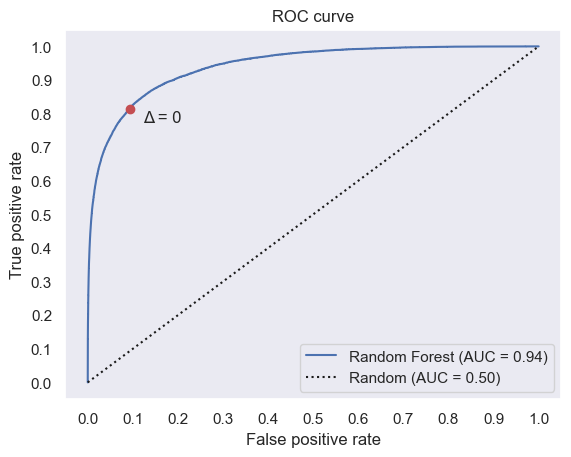

In [49]:
roc_curve_(y_test, pipe.predict_proba(X_test), pipe.predict(X_test), 'Random Forest')

#### XGBoost

In [ ]:
param_grid = {
    'xgbclassifier__learning_rate': np.logspace(-4, -1, 5),
    'xgbclassifier__max_depth': np.logspace(3, 7, num=5, base=2).astype(int),
    'xgbclassifier__gamma': np.logspace(-3, -1, 5),
    'xgbclassifier__reg_alpha': np.logspace(-4, 2, 6),
    'xgbclassifier__reg_lambda': np.logspace(-4, 2, 6),
    'xgbclassifier__subsample': np.linspace(0.5, 1, 3),
}


model = randomized_search(XGBClassifier(random_state=42, n_estimators=50, booster='gbtree'), param_grid, X_train_reduced_20, y_train_20)


,Mean Test Roc AUC,Mean Train Roc AUC,Mean Test Balanced Accuracy,Learning Rate,Max Depth,Gamma,Reg Alpha,Reg Lambda,Subsample
9,0.917185,0.999996,0.707130,0.1,32,0.1,0.025119,0.001585,0.75
27,0.908150,0.975510,0.681199,0.1,64,0.001,0.398107,6.309573,0.75
13,0.902966,0.965853,0.672206,0.1,32,0.001,0.001585,6.309573,0.5
26,0.902009,0.954345,0.673061,0.1,8,0.031623,0.001585,0.001585,0.5
33,0.892407,0.965369,0.679630,0.017783,64,0.01,0.0001,0.398107,0.75
21,0.891207,0.983982,0.667032,0.003162,32,0.031623,0.025119,0.0001,0.5
3,0.888455,0.997222,0.679975,0.003162,64,0.01,0.001585,0.025119,0.75
19,0.888000,0.943181,0.668067,0.017783,128,0.1,0.398107,0.001585,0.5
20,0.882029,0.919367,0.658930,0.003162,16,0.031623,0.001585,0.001585,0.5
4,0.881820,0.918683,0.659415,0.003162,16,0.003162,0.025119,0.001585,0.5


In [54]:
# Retreinando com todos os dados e testando no conjunto de teste
xgb_best_params = {
    'gamma': 0.1,
    'max_depth': 32,
    'learning_rate': 0.1,
    'reg_alpha': 0.025119,
    'reg_lambda': 0.001585,
    'subsample': 0.75,
    'random_state': 42,
    'n_estimators': 50
}

encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector),
    (SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number),)
    )
    
xgb_pipe = make_pipeline(encode_categorical,
                    XGBClassifier(**xgb_best_params))

xgb_pipe.fit(pd.concat([X_train_reduced, X_val_reduced]), pd.concat([y_train, y_val]))

y_pred_balanced_acc = xgb_pipe.predict(X_test)
y_pred_roc_auc = xgb_pipe.predict_proba(X_test)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_balanced_acc)}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, y_pred_roc_auc)}")

Balanced Accuracy: 0.9163667319551593
Test ROC-AUC score: 0.9972563577206948


 True negative rate: 100.0%
False positive rate:   0.0%
False negative rate:  16.7%
 True positive rate:  83.3%



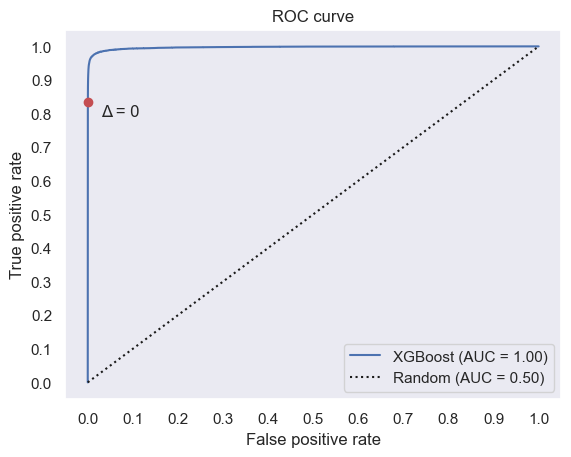

In [55]:
roc_curve_(y_test, xgb_pipe.predict_proba(X_test), xgb_pipe.predict(X_test), 'XGBoost')

#### LightGBM

In [ ]:
param_grid = {
    'lgbmclassifier__learning_rate': np.logspace(-4, -1, 5),
    'lgbmclassifier__max_depth': np.logspace(3, 7, num=5, base=2).astype(int),
    'lgbmclassifier__min_split_gain': np.logspace(-3, -1, 5),
    'lgbmclassifier__reg_alpha': np.logspace(-4, 0, 6),
    'lgbmclassifier__reg_lambda': np.logspace(-4, 0, 6),
    'lgbmclassifier__subsample': np.linspace(0.5, 1, 3),
}

model = randomized_search(LGBMClassifier(random_state=42, n_estimators=50, class_weight='balanced', boosting_type='gbdt'), param_grid, X_train_reduced_20, y_train_20)

,Mean Test Roc AUC,Mean Train Roc AUC,Mean Test Balanced Accuracy,Learning Rate,Max Depth,Min Split Gain,Reg Alpha,Reg Lambda,Subsample
1,0.907020,0.947176,0.829154,0.1,16,0.001,0.0001,1.0,0.5
0,0.906956,0.947576,0.828066,0.1,128,0.031623,0.158489,1.0,0.75
5,0.906798,0.948308,0.826746,0.1,64,0.01,0.003981,0.0001,0.5
21,0.906415,0.948296,0.827404,0.1,64,0.01,0.025119,0.025119,0.75
25,0.906376,0.947103,0.829022,0.1,32,0.003162,0.0001,1.0,1.0
23,0.906326,0.947801,0.828251,0.1,128,0.1,0.158489,0.000631,1.0
12,0.906165,0.948395,0.826150,0.1,64,0.031623,0.000631,0.158489,1.0
10,0.905632,0.948064,0.826097,0.1,16,0.031623,0.158489,0.003981,0.75
27,0.903354,0.944092,0.826644,0.1,8,0.001,0.0001,0.000631,0.5
19,0.875828,0.892786,0.798513,0.017783,64,0.031623,0.158489,1.0,0.5


In [56]:
gbm_best_params = {
    'min_split_gain': 0.001,
    'learning_rate': 0.1,
    'max_depth': 16,
    'reg_alpha': 0.0001,
    'reg_lambda': 1,
    'subsample': 0.5,
    'random_state': 42,
    'n_estimators': 50
}

encode_categorical = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore"), categorical_selector),
    (SimpleImputer(strategy='median'), make_column_selector(dtype_include=np.number),)
    )
    
gbm_pipe = make_pipeline(encode_categorical,
                    XGBClassifier(**gbm_best_params))

gbm_pipe.fit(pd.concat([X_train_reduced, X_val_reduced]), pd.concat([y_train, y_val]))

y_pred_balanced_acc = gbm_pipe.predict(X_test)
y_pred_roc_auc = gbm_pipe.predict_proba(X_test)[:, 1]

print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_balanced_acc)}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, y_pred_roc_auc)}")

[23:07:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "min_split_gain" } are not used.

Balanced Accuracy: 0.8085950725557246
Test ROC-AUC score: 0.9817914172780624


 True negative rate:  99.9%
False positive rate:   0.1%
False negative rate:  38.2%
 True positive rate:  61.8%



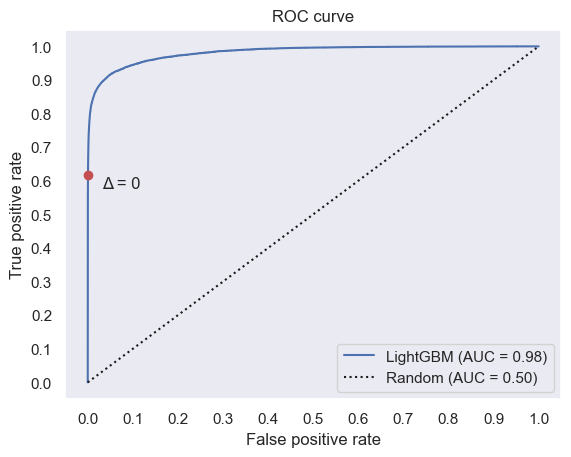

In [57]:
roc_curve_(y_test, gbm_pipe.predict_proba(X_test), gbm_pipe.predict(X_test), 'LightGBM')